# 1. Simulation

This part is a discrete simulation of a gas diffusion in a open area.
The gaz is continuously released from a source and diffuses in the area.

Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from itertools import combinations_with_replacement
from multiprocessing import Pool, cpu_count
from collections import defaultdict

Define a builder class to create the simulation environment

In [2]:
class FickDiffusionBuilder():

    def __init__(self):
        self.size = (10, 10)

        self.points = (50, 50)
        
        self.source_rate = 10
        
        self.source_position = (5, 5)
        
        self.dt = 0.1
        
        self.D = 1

    def set_size(self, size):
        """
        Set the size of the grid in meters

        Parameters:

        size : tuple
            The size of the grid in meters (x, y)
        """
        self.size = size
        return self

    def set_points(self, points):
        """
        Set the number of points in the grid in each dimension (grid resolution)

        Parameters:
        
        points : tuple
            The number of points in the grid in each dimension (x, y)
        """
     
        self.points = points
        return self

    def set_source_rate(self, source_rate):
        """
        Set the source rate of the particles in particles per second

        Parameters:

        source_rate : float
            The source rate of the particles in particles per second        
        """

        self.source_rate = source_rate
        return self
    
    def set_source_position(self, source_position):
        """
        Set the position of the source in the grid

        Parameters:

        source_position : tuple
            The position of the source in the grid (x, y)
        """

        self.source_position = source_position
        return self

    def set_time_step(self, dt):
        """
        Set the time step of the simulation in seconds

        Parameters:

        dt : float
            The time step of the simulation in seconds
        """
        
        self.dt = dt
        return self

    def set_diffusion_coefficient(self, D):
        """
        Set the diffusion coefficient of the particles in the medium in m^2/s

        Parameters:

        D : float
            The diffusion coefficient of the particles in the medium
        """
        
        self.D = D
        return self

    def build(self):
        """
        Build the FickDiffusion object with the specified parameters

        Returns:

        FickDiffusion
            The FickDiffusion object with the specified parameters
        """

        return FickDiffusion(self.size, self.points, self.source_rate, self.source_position, self.dt, self.D)

We need to place somewhere the pseudo sensors that will be used to measure the concentration of the gaz in the area at different distances. In order to have the greatest distance coverage, we place then on the longest distance that separates the source from the border of the area. For that, we need to calculate the discrete line between two points. We will use the Bresenham algorithm to do that.

In [3]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy 

    while True:
        points.append((x0, y0))

        if x0 == x1 and y0 == y1:
            break
               
        e2 = 2 * err
        if e2 >= dy:  
            err += dy
            x0 += sx
        if e2 <= dx:  
            err += dx
            y0 += sy
            
    return np.array(points)

Simulate gas diffusion in a plane following Fick's 2nd law of diffusion :

$$
\frac{\delta C}{\delta t} = D \nabla^2 C
$$

where $C$ is the concentration of the gas, $D$ is the diffusion coefficient and $\nabla^2 C$ is the Laplacian operator : 

$$
\nabla^2 C = \frac{\delta^2 C}{\delta x^2} + \frac{\delta^2 C}{\delta y^2}
$$

Using the finite difference method, we can approximate the Laplacian operator as follows :

$$
\frac{\delta^2 C}{\delta x^2} \approx \frac{C_{i+1,j} - 2C_{i,j} + C_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\delta^2 C}{\delta y^2} \approx \frac{C_{i,j+1} - 2C_{i,j} + C_{i,j-1}}{\Delta y^2}
$$

where $\Delta x$ and $\Delta y$ are the steps in the $x$ and $y$ directions.


In [4]:
def diffuse(C, D, dt, dx, dy):
    """
    Diffuse the gas in the area using the Fick's second law of diffusion

    # Parameters:

    - C (numpy.ndarray): The concentration matrix of the gas in the area
    - D (float): The diffusion coefficient of the gas in the medium
    - dt (float): The time step of the simulation in seconds
    - dx (float): The distance between two points in the x direction in meters
    - dy (float): The distance between two points in the y direction in meters
    
    Returns:

    numpy.ndarray
        The reference of concentration matrix of the gas in the area after diffusion (this is not a copy)
    """

    # Laplacian of C
    d2C_dx2 = (np.roll(C, 1, axis=0) - 2 * C + np.roll(C, -1, axis=0)) / dx**2
    d2C_dy2 = (np.roll(C, 1, axis=1) - 2 * C + np.roll(C, -1, axis=1)) / dy**2
    # We use np.roll since it is faster than for loops

    # Diffusion equation
    dC_dt = D * (d2C_dx2 + d2C_dy2)
        
    # Time integration
    C += dt * dC_dt
        
    # Boundary conditions (necessary in order to use np.roll + simulate an open area)
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

    return C

Since our simulation is dealing with partial differential equations, we need to use a numerical method to solve it. We will use the finite difference method to solve the diffusion equation. However we have to ensure the stability of calculation by respecting the Courant-Friedrichs-Lewy (CFL) condition :

$$
\frac{D \Delta t}{\Delta x^2} + \frac{D \Delta t}{\Delta y^2} \leq \frac{1}{2}
$$

where $\Delta t$ is the time step and $D$ is the diffusion coefficient.


In [5]:
def get_courant_friedrichs_lewy_coefficient(D, dt, dx, dy):
    """
    Get the Courant-Friedrichs-Lewy (CFL) coefficient for the simulation

    # Parameters:

    - D (float): The diffusion coefficient of the gas in the medium in m^2/s
    - dt (float): The time step of the simulation in seconds
    - dx (float): The distance between two points in the x direction in meters
    - dy (float): The distance between two points in the y direction in meters
    
    # Returns:
    float : The Courant-Friedrichs-Lewy (CFL) coefficient for the simulation
    """
    
    return ((D * dt) / (dx**2)) + ((D * dt) / (dy**2))

Since we will diffuse the gaz at a single point in the area at a constant rate, we have the simple function :

In [6]:
def release_gaz(C, source_x, source_y, source_rate):
    """
    Release gas from a source in the area

    # Parameters:

    - C (numpy.ndarray) : The concentration matrix of the gas in the area
    - source_x (int) : The x position of the source in the area
    - source_y (int) : The y position of the source in the area
    - source_rate (float) : The rate of the gas released from the source in particles per second
    Returns:

    - numpy.ndarray : The reference of concentration matrix of the gas in the area after releasing gas from the source (this is not a copy)
    """

    C[source_x, source_y] = source_rate
    return C

Here is the wrapping class that will simulate the gas diffusion in the area.

In [7]:
class FickDiffusion():
    def __init__(self, size, points, source_rate, source_position, dt, D):
        # Size of the area
        self.length = size[0]
        self.width = size[1]
    
        # Number of grid points
        self.nx = points[0]
        self.ny = points[1]

        # Grid spacing
        self.dx = self.length / self.nx
        self.dy = self.width / self.ny
        
        # Time step
        self.dt = dt

        # Gas diffusion coefficient
        self.D = D * dt

        # Check the Courant-Friedrichs-Lewy stability condition
        courant_friedrichs_lewy = get_courant_friedrichs_lewy_coefficient(self.D, self.dt, self.dx, self.dy)

        if courant_friedrichs_lewy > 0.5:
            raise ValueError(f"Courant-Friedrichs-Lewy condition not met ({courant_friedrichs_lewy} > 0.5), please reduce the time step or increase the grid resolution")
        
        # Source release rate
        self.source_rate = source_rate * self.dt
       
        # Source location (offset from the center)
        self.source_x, self.source_y = self.get_grid_position(source_position[0], source_position[1])    

    def get_grid_position(self, x, y):
        """
        Convert the real-world coordinates to grid coordinates

        Parameters:
        - x: the x coordinate in meters
        - y: the y coordinate in meters
        """
        return (int(x / self.dx), int(y / self.dy))

    def animate(self, final_time, source_start=0, source_end=None):
        """
        Animate the diffusion of gas in the area for a given time
        and return the animation object

        Parameters:
        - final_time: the final time of the simulation
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - ani: the animation object
        """

        # Initialize the concentration matrix
        C = np.zeros((self.nx, self.ny))
        C = release_gaz(C, self.source_x, self.source_y, self.source_rate)

        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time

        # Create the figure and axis
        fig, ax = plt.subplots()
        im = ax.imshow(C, cmap='hot', interpolation='nearest', animated=True)   
        text_label = ax.text(0.5, 1.01, '', transform=ax.transAxes, ha="center", va="bottom")
        
        def animation_function(i):
            """
            Animation callback function that updates the concentration of gas in the area.
            """
            nonlocal C
            t = self.get_current_time(i)

            # Simulate the diffusion of gas in the area
            C = self.simulate(C, t, source_start, source_end)

            # Update the image and text label
            im.set_array(C)
            text_label.set_text(f"Frame {i} - Time {i*self.dt:.2f}s")

            return im,
            
        ani = animation.FuncAnimation(fig, animation_function, frames=range(int(final_time//self.dt)), interval=int(self.dt*1000), blit=True)
        return ani

    def generate_training_data(self, final_time, source_start=0, source_end=None):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the pseudo-sensor data (sensor data at the diagonal line)

        Parameters:
        - final_time: the final time of the simulation
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - x: the x coordinates of the pseudo-sensors
        - y: the y coordinates of the pseudo-sensors
        - time: the time of the simulation
        - values: the concentration values at the pseudo-sensors
        """

        # Initialize the concentration matrix
        C = self.create_concentration_matrix()

        iterations = int(final_time//self.dt)

        # Pseudo-sensors diagonal line
        diagonal = self.get_diagonal_line()   

        # Compute the real coordinates of the pseudo-sensors
        real_coordinates = diagonal.copy() * np.array([self.dx, self.dy])

        # Create the different matrices to store the data
        values = np.zeros((len(diagonal), iterations))
        x = np.zeros_like(values)
        y = np.zeros_like(values)
        time = np.zeros_like(values)
        
        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time
            
        # Iterate over the time steps
        for i in range(iterations):
            # Current time
            t = self.get_current_time(i)

            # Simulate the diffusion of gas in the area
            C = self.simulate(C, t, source_start, source_end)

            # Collect the pseudo-sensor data
            for j, (map_coordinates, real_coordinate) in enumerate(zip(diagonal, real_coordinates)):
                x[j, i] = real_coordinate[0]
                y[j, i] = real_coordinate[1]
                time[j, i] = t
                values[j, i] = C[map_coordinates[0], map_coordinates[1]]

        return x, y, time, values

    def generate_testing_data(self, final_time, sensors_positions, source_start=0, source_end=None):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the pseudo-sensor data (sensor data at the given sensors positions)

        Parameters:
        - final_time: the final time of the simulation
        - sensors_positions: the positions of the pseudo-sensors
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - time: the time of the simulation
        - values: the concentration values at the pseudo-sensors
        """

        C = self.create_concentration_matrix()

        iterations = int(final_time//self.dt)

        # Compute the real coordinates of the pseudo-sensors
        map_coordinates = [self.get_grid_position(x, y) for x, y in sensors_positions]

        # Create the different matrices to store the data
        values = np.zeros((len(sensors_positions), iterations))
        time = np.zeros_like(values)

        # If the source end is not specified, we assume that the source will release gas until the end of the simulation
        if source_end is None:
            source_end = final_time

        # Iterate over the time steps
        for i in range(iterations):
            # Current time
            t = self.get_current_time(i)

            # Simulate the diffusion of gas in the area
            C = self.simulate(C, t, source_start, source_end)

            # Collect the pseudo-sensor data
            for j, coordinates in enumerate(map_coordinates):
                values[j, i] = C[coordinates[0], coordinates[1]]
                time[j, i] = t

        return time, values
        
    def simulate(self, C, t, source_start, source_end):
        """
        Simulate the diffusion of gas in the area for a given time
        and return the concentration matrix

        Parameters:
        - C: the concentration matrix
        - t: the current time
        - source_start: the time at which the source starts releasing gas
        - source_end: the time at which the source stops releasing gas

        Returns:
        - C: the concentration matrix
        """

        # Release gas if the time is within the source start and end time
        if t >= source_start and t <= source_end:
            release_gaz(C, self.source_x, self.source_y, self.source_rate)

        # Diffuse the gas in the area
        C = diffuse(C, self.D, self.dt, self.dx, self.dy)

        return C

    def get_diagonal_line(self):
        """
        Get the diagonal line of the area (from the source to the opposite corner of the area using Bresenham's algorithm)

        Returns:
        - diagonal: the diagonal line
        """

        x_0 = self.source_x
        y_0 = self.source_y

        # We want to find the map edges that are the furthest from the source
        if x_0 > self.nx - x_0:
            x_1 = 0
        else:
            x_1 = self.nx - 1

        if y_0 > self.ny - y_0:
            y_1 = 0
        else:
            y_1 = self.ny - 1

        # Compute the diagonal line using Bresenham's algorithm
        return bresenham_line(x_0, y_0, x_1, y_1)[1:]

    def create_concentration_matrix(self):
        """
        Create the concentration matrix

        Returns:
        - C: the concentration matrix
        """
        C = np.zeros((self.nx, self.ny))
        return C

    def get_current_time(self, i):
        """
        Get the current time of the simulation given the iteration i

        Parameters:
        - i: the current iteration

        Returns:
        - t: the current time
        """
        return i * self.dt

Show the animation of the gas diffusion in the area.

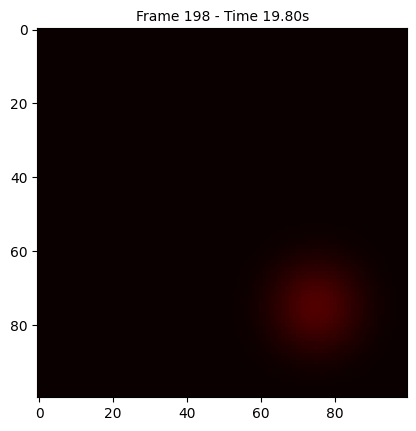

In [8]:
ani = (FickDiffusionBuilder()
    .set_points((100, 100))
    .set_size((20, 20))
    .set_source_position((15,15))
    .build()
    .animate(20, source_end=10))

HTML(ani.to_html5_video())


In [9]:
def filter_sensors(values):
    """
    Filter the sensors data by removing the sensors that have a constant value
    """
    return np.where(np.std(values, axis=1) > 0.01)

Let's generate for multiple diffusion coefficients $D$ and store the results in a CSV file for later use.


In [10]:
def simulate_environment(source_x, source_y, D, environment_index):
    print(f"Simulating source at ({source_x}, {source_y}) with D={D}")

    x, y, time, value = (FickDiffusionBuilder()
        .set_points((100, 100))
        .set_size((20, 20))
        .set_source_position((source_x, source_y))
        .set_diffusion_coefficient(D)
        .build()
        .generate_training_data(200, source_end=150))

    # Filter the sensors that have a constant value
    valid_index = filter_sensors(value)

    value = value[valid_index]
    x = x[valid_index]
    y = y[valid_index]
    time = time[valid_index]

    signal_identifier = np.arange(value.shape[0]).repeat(value.shape[1]).reshape(value.shape)
    # signal_index += current_values.shape[0]
    
    environment_identifier = np.ones_like(signal_identifier) * environment_index
    # environment_index += 1
    
    #current_mean = current_values.mean(axis=1).repeat(current_values.shape[1]).reshape(current_values.shape)
    #current_std = current_values.std(axis=1).repeat(current_values.shape[1]).reshape(current_values.shape)
    
    #values_mean.append(current_mean)
    #values_std.append(current_std)

    # - - Store the data
    D = np.ones_like(value) * D

    source_x = np.ones_like(value) * source_x
    source_y = np.ones_like(value) * source_y

    #source_positions_x.append(np.ones_like(current_values) * source_x)
    #source_positions_y.append(np.ones_like(current_values) * source_y)

    #diffusion_coefficients.append(current_D)

    #values.append(current_values)
    #x.append(current_x)
    #y.append(current_y)
    #time.append(current_time)

    # distances_to_source.append(np.sqrt((current_x - source_x)**2 + (current_y - source_y)**2))

    # print(f"Sensor data shape: {current_values.shape}, source position: ({source_x}, {source_y})")

    # for i in range(current_values.shape[0]):
    #     if current_values[i].max() > 0:
    #         print(f"Pos : ({current_x[i, 0]:.2f}, {current_y[i, 0]:.2f}) - d: {distances_to_source[-1][i, 0]:.2f} - v: {current_values[i].mean()}")

    # - Return the data in a dictionary format for better handling        
    return {
        "environment_identifier": environment_identifier,
        "signal_identifier": signal_identifier,
        "x": x,
        "y": y,
        "time": time,
        "values": value,
        "D": D,
        "source_x": source_x,
        "source_y": source_y
    }


arguments_list = []
environment_index = 0

# - Prepare the arguments list for the simulation with different environments (source positions and diffusion coefficients)
for source_x, source_y in combinations_with_replacement(np.linspace(5, 15, 5), 2):
    for D in np.linspace(0.1, 1, 10):
        arguments_list.append((source_x, source_y, D, environment_index))
      
        environment_index += 1


print(f"Simulating {len(arguments_list)} environments")

# - Simulate the environments in parallel using all the available CPUs cores
with Pool(cpu_count()) as pool:
    raw_results = pool.starmap(simulate_environment, arguments_list)

Simulating 150 environments
Simulating source at (5.0, 5.0) with D=0.30000000000000004Simulating source at (5.0, 5.0) with D=0.5Simulating source at (5.0, 5.0) with D=0.1Simulating source at (5.0, 5.0) with D=0.7000000000000001Simulating source at (5.0, 5.0) with D=0.9Simulating source at (5.0, 7.5) with D=0.30000000000000004Simulating source at (5.0, 7.5) with D=0.1Simulating source at (5.0, 7.5) with D=0.7000000000000001
Simulating source at (5.0, 7.5) with D=0.9
Simulating source at (5.0, 10.0) with D=0.1Simulating source at (5.0, 10.0) with D=0.9Simulating source at (5.0, 7.5) with D=0.5
Simulating source at (5.0, 10.0) with D=0.5
Simulating source at (5.0, 10.0) with D=0.30000000000000004
Simulating source at (5.0, 10.0) with D=0.7000000000000001Simulating source at (5.0, 12.5) with D=0.1Simulating source at (5.0, 12.5) with D=0.9Simulating source at (5.0, 12.5) with D=0.5Simulating source at (5.0, 12.5) with D=0.7000000000000001Simulating source at (5.0, 12.5) with D=0.3000000000

In [11]:
results = defaultdict(list)

# Transform the list of dictionaries into a dictionary of lists
for raw_result in raw_results:
    for key, value in raw_result.items():
        results[key].append(value) 

# Concatenate the lists of numpy arrays into a single numpy array
for key, value in results.items():
    results[key] = np.concatenate(value).flatten()
    print(f"Shape of {key}: {results[key].shape}")

print(f"Accumulated results: {results.keys()}")

Shape of environment_identifier: (6664666,)
Shape of signal_identifier: (6664666,)
Shape of x: (6664666,)
Shape of y: (6664666,)
Shape of time: (6664666,)
Shape of values: (6664666,)
Shape of D: (6664666,)
Shape of source_x: (6664666,)
Shape of source_y: (6664666,)
Accumulated results: dict_keys(['environment_identifier', 'signal_identifier', 'x', 'y', 'time', 'values', 'D', 'source_x', 'source_y'])


Put the data into a data frame and save it to a CSV file.

In [12]:
# Concatenate all the vectors and create the data frame
data_frame = pd.DataFrame({
    "environment_identifier": results["environment_identifier"],
    "signal_identifier": results["signal_identifier"],
    "diffusion_coefficient": results["D"],
    "x": results["x"],
    "y": results["y"],
    "time": results["time"],
    "value": results["values"],
    #"distances_to_source": distances_to_source,
    #"relative_offsets": relative_offsets,
    "source_x": results["source_x"],
    "source_y": results["source_y"],
    #"values_mean": values_mean,
    #"values_std": values_std
})

# Save the data frame to a HDF5 file (faster for large datasets)
data_frame.to_hdf("raw_data.h5", key="raw_data", mode="w")